# AEVB for VAE

## Import

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%config InlineBackend.figure_formats = ['svg']
from scipy.signal import savgol_filter

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as d
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [24]:
from sklearn.manifold import TSNE

In [25]:
import time
from tqdm import tqdm
from copy import deepcopy
import os
import pickle

In [26]:
def add_subplot_axes(ax,rect,facecolor='w'): # matplotlib 2.0+
# def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
#     subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

## Data

In [27]:
from keras.datasets.mnist import load_data

In [28]:
(x_train, y_train), (x_test, y_test) = load_data()

x_train = x_train + np.random.uniform(low=0, high=1, size=x_train.shape)
x_train = x_train / 256
x_train = x_train.reshape(-1, 28*28)

x_test = x_test + np.random.uniform(low=0, high=1, size=x_test.shape)
x_test = x_test / 256
x_test = x_test.reshape(-1, 28*28)

train_ds = TensorDataset(torch.from_numpy(x_train).float())
train_dl = DataLoader(train_ds, batch_size=32)

test_ds = TensorDataset(torch.from_numpy(x_test).float())
test_dl = DataLoader(test_ds, batch_size=1000)

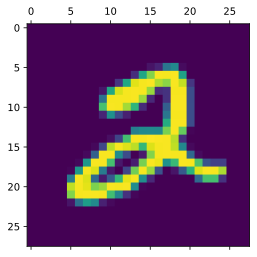

In [29]:
plt.matshow(x_train[5].reshape(28, 28))

## Modules

In [30]:
Ind = d.Independent
CB = d.ContinuousBernoulli
Normal = d.Normal

In [31]:
class p_x_given_z_class(nn.Module):
    """
    p_x_given_z
    Take in latent vectors, output distribution over images
    """

    def __init__(self, z_dim, x_dim):
        super().__init__()
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.lambdas = nn.Sequential(
            
            nn.Linear(z_dim, 500),
            nn.ReLU(),
            
            nn.Dropout(0.1),
            
            nn.Linear(500, 500),
            nn.ReLU(),
            
            nn.Dropout(0.1),
            
            nn.Linear(500, x_dim),
            nn.Sigmoid()  # -> (0, 1)
        )

    def forward(self, zs):
        return Ind(CB(self.lambdas(zs)), 1)

In [32]:
class q_z_given_x_class(nn.Module):
    """
    q_z_given_x
    Take in image, output distribution over latent vectors
    """

    def __init__(self, z_dim, x_dim):
        super().__init__()
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.shared = nn.Sequential(
            
            nn.Linear(x_dim, 500),
            nn.ReLU(),
            
            nn.Dropout(0.1),
            
            nn.Linear(500, 500),
            nn.ReLU(),
            
            nn.Dropout(0.1),
        
        )
        self.mus = nn.Linear(500, z_dim)
        self.sigmas = nn.Sequential(
            nn.Linear(500, z_dim),
            nn.Softplus()  # -> (0, infinity)
        )

    def forward(self, xs):
        xs = self.shared(xs)
        return Ind(Normal(self.mus(xs), self.sigmas(xs)), 1)

## AEVB

In [33]:
class ImageDLVM:
    """
    This is the VAE class. I personally don't like the name VAE and I prefer DLVM, which stands for Deep Latent Variable Model. This name seems to be
    better connected with theory, e.g., latent variable models, expectation maximization and so on.
    """

    def __init__(self, z_dim, x_dim, lr=3e-4):

        # hyper-parameters
        self.z_dim = z_dim
        self.x_dim = x_dim
        self.lr = lr

        # describes the generative process
        self.p_z = Ind(Normal(torch.zeros(z_dim), torch.ones(z_dim)), 1)
        self.p_x_given_z = p_x_given_z_class(z_dim=z_dim, x_dim=x_dim)

        # required for approximate posterior inference
        self.q_z_given_x = q_z_given_x_class(z_dim=z_dim, x_dim=x_dim)

        # gradient-based optimizers
        self.p_x_given_z_opt = optim.Adam(self.p_x_given_z.parameters(), lr=lr)
        self.q_z_given_x_opt = optim.Adam(self.q_z_given_x.parameters(), lr=lr)

    def step(self, xs, evaluate=False):
        if evaluate:
            self.p_x_given_z.eval()
            self.q_z_given_x.eval()
        else:
            self.p_x_given_z.train()
            self.q_z_given_x.train()
        posterior_over_zs = self.q_z_given_x(xs)
        # kl-divergence
        kl = d.kl.kl_divergence(posterior_over_zs, self.p_z).mean()
        # reconstruction
        zs = posterior_over_zs.rsample()  # sample using the re-parametrization trick
        #kl = ((posterior_over_zs.log_prob(zs) - self.p_z.log_prob(zs))).mean()
        rec = self.p_x_given_z(zs).log_prob(xs).mean()
        # elbo (estimated using one sample per posterior)
        elbo = - kl + rec
        # backpropagation and gradient step
        loss = - elbo
        if not evaluate:
            self.p_x_given_z_opt.zero_grad()
            self.q_z_given_x_opt.zero_grad()
            loss.backward()
            self.p_x_given_z_opt.step()
            self.q_z_given_x_opt.step()
        return {
            "kl": float(kl),  # this is at least 0; the smaller the better
            "rec": float(rec),  # the larger the better
            "elbo": float(elbo)  # the larger the better
        }

    def encode(self, xs):
        with torch.no_grad():
            return self.q_z_given_x(xs).mean

    def generate(self, n, mode):
        self.p_x_given_z.eval()
        self.q_z_given_x.eval()
        with torch.no_grad():
            if mode == "mean":
                return self.p_x_given_z(self.p_z.sample((n, ))).mean
            elif mode == "sample":
                return self.p_x_given_z(self.p_z.sample((n, ))).sample()
            elif mode == "param":
                return self.p_x_given_z.lambdas(model.p_z.sample((n, )))
            else:
                raise ValueError(f"{mode} is not a valid mode for generate.")

    def save(self, save_dir):
        torch.save(self.p_x_given_z.state_dict(), os.path.join(save_dir, "p_x_given_z.pth"))
        torch.save(self.q_z_given_x.state_dict(), os.path.join(save_dir, "q_z_given_x.pth"))

    def load(self, save_dir):
        self.p_x_given_z.load_state_dict(
            torch.load(os.path.join(save_dir, "p_x_given_z.pth"), map_location=torch.device("cpu"))
        )
        self.q_z_given_x.load_state_dict(
            torch.load(os.path.join(save_dir, "q_z_given_x.pth"), map_location=torch.device("cpu"))
        )

## Training

In [34]:
# model = ImageDLVM(z_dim=20, x_dim=28*28)

# test_elbos = []

# for epoch in range(100):
#     print(epoch)
#     for (xb, ) in train_dl:
#         stats_dict = model.step(xb)
#     test_elbos.append(np.mean([model.step(xb, evaluate=True)["elbo"] for (xb, ) in test_dl]))

# with open("test_elbos", "wb") as fp:
#     pickle.dump(test_elbos, fp)

In [35]:
# or just load model I already trained :)
model = ImageDLVM(z_dim=20, x_dim=28*28)
model.load(".")
with open("test_elbos", "rb") as fp:
     test_elbos = pickle.load(fp)

## ELBO plot

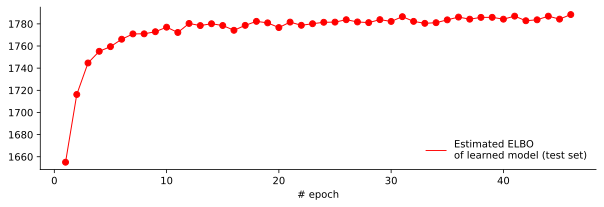

In [36]:
plt.figure(figsize=(10, 3))

# plt.plot(elbos, linewidth=1, color="red", alpha=0.3)
plt.plot(range(1, len(test_elbos)+1), test_elbos, linewidth=1, color="red", label="Estimated ELBO\nof learned model (test set)")
plt.scatter(range(1, len(test_elbos)+1), test_elbos, color="red")
plt.xlabel("# epoch")
# plt.xticks(np.arange(1, 16))
# plt.xlim(1, 15)

plt.legend(loc="lower right", frameon=False)

plt.gca().spines.right.set_visible(False)
plt.gca().spines.top.set_visible(False)

plt.savefig("vae_learning_curve.pdf", bbox_inches='tight', pad_inches = 0)

## Original MNIST

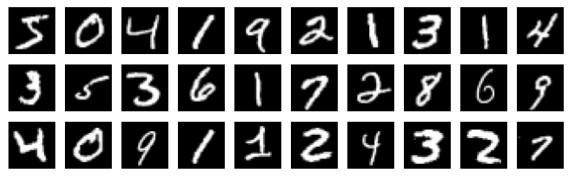

In [37]:
plt.figure(figsize=(10, 3))
for i in range(1, 31):
    plt.subplot(3, 10, i)
    plt.imshow(x_train[i-1].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.savefig("vae_mnist_orgs.pdf", bbox_inches='tight', pad_inches = 0)

## Generated MNIST

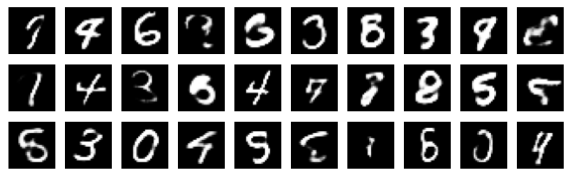

In [38]:
torch.manual_seed(10)
gens = model.generate(n=100, mode="param").numpy()
plt.figure(figsize=(10, 3))
for i in range(1, 31):
    plt.subplot(3, 10, i)
    plt.imshow(gens[i-1].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.savefig("vae_mnist_gens_param.pdf", bbox_inches='tight',pad_inches = 0)

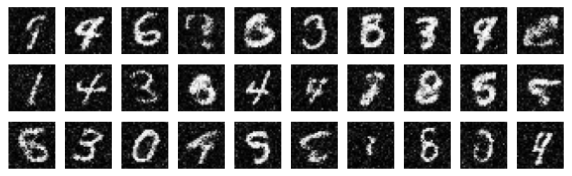

In [39]:
torch.manual_seed(10)
gens = model.generate(n=100, mode="sample").numpy()
plt.figure(figsize=(10, 3))
for i in range(1, 31):
    plt.subplot(3, 10, i)
    plt.imshow(gens[i-1].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.savefig("vae_mnist_gens_sample.pdf", bbox_inches='tight',pad_inches = 0)

## T-SNE

In [40]:
test_latents = model.q_z_given_x(torch.from_numpy(x_test).float()).mean.detach().numpy()

In [41]:
tsne_results = TSNE().fit_transform(test_latents)

/Users/zhihanyang/opt/miniconda3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/zhihanyang/opt/miniconda3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


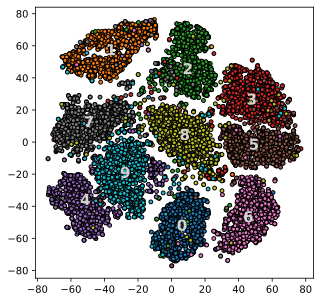

In [42]:
plt.figure(figsize=(5, 5))
for g in np.unique(y_test):
    i = np.where(y_test == g)
    plt.scatter(tsne_results[:, 0][i], tsne_results[:, 1][i], s=15, edgecolor='black')
    median_x = np.median(tsne_results[:, 0][i])
    median_y = np.median(tsne_results[:, 1][i])
    plt.annotate(g, xy=(median_x, median_y), xytext=(-5, -5), textcoords="offset points",
                 color="lightgray", fontsize=15, weight="bold")
plt.savefig("vae_tsne.pdf", bbox_inches='tight',pad_inches = 0)